In [1]:
!pip install koreanize_matplotlib

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.9/7.9 MB 35.1 MB/s eta 0:00:00


# 1. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [2]:
import pandas as pd
import numpy as np
import re
import random
import os
from tqdm.auto import tqdm

In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn

In [4]:
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
import itertools
from itertools import permutations
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

In [5]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [6]:
print(torch.cuda.is_available())

True


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/Í∞ïÏùò/AIÎ•º ÏúÑÌïú Îî•Îü¨Îãù/AI_DL_Project/code

/content/drive/MyDrive/Í∞ïÏùò/AIÎ•º ÏúÑÌïú Îî•Îü¨Îãù/AI_DL_Project/code


In [10]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [11]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7351 entries, 0 to 7350
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          7351 non-null   object
 1   sentence_0  7351 non-null   object
 2   sentence_1  7351 non-null   object
 3   sentence_2  7351 non-null   object
 4   sentence_3  7351 non-null   object
 5   answer_0    7351 non-null   int64 
 6   answer_1    7351 non-null   int64 
 7   answer_2    7351 non-null   int64 
 8   answer_3    7351 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 517.0+ KB


ID                                         sentence_0  \
0  TRAIN_0000                 Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§.   
1  TRAIN_0001  Ï§ÑÍ±∞Î¶¨ ÏûêÎèô ÏÉùÏÑ±Ïùò Ïù∏Í≥µÏßÄÎä• ÏïåÍ≥†Î¶¨Ï¶òÏùÄ ÎåÄÎüâÏùò ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÏÑùÌïòÏó¨ ÌïµÏã¨ Ï†ïÎ≥¥Î•º...   
2  TRAIN_0002  ÎßàÏßÄÎßâÏúºÎ°ú, ÌÇ§ÏπúÌÉÄÏò¨ÏùÑ Î≥¥Í¥ÄÌï† ÎïåÎäî ÏâΩÍ≤å Ï†ëÍ∑ºÌï† Ïàò ÏûàÎäî Í≥≥Ïóê ÎëêÏñ¥ ÎÇ≠ÎπÑÎ•º Î∞©ÏßÄÌïòÎäî...   
3  TRAIN_0003   Ï±ÖÏùò ÌéòÏù¥ÏßÄÍ∞Ä ÏÜêÏÉÅÎêòÏßÄ ÏïäÎèÑÎ°ù ÏàòÏßÅÏúºÎ°ú ÏÑ∏Ïõå ÎëêÍ±∞ÎÇò ÌèâÌèâÌïòÍ≤å ÎàïÌòÄ Î≥¥Í¥ÄÌïòÎäî Í≤ÉÏù¥ Ï¢ãÎã§.   
4  TRAIN_0004  Ïù∏Í≥µÏßÄÎä• Î™®Îç∏ÏùÄ Î∞òÎ≥µÏ†ÅÏù∏ Ïã§ÌóòÏùÑ ÌÜµÌï¥ ÏßÄÏÜçÏ†ÅÏúºÎ°ú ÌïôÏäµÌïòÎ©∞, Ïù¥Î•º ÌÜµÌï¥ Î∞úÍ≤¨Ïùò Ï†ïÌôïÏÑ±...   

                                          sentence_1  \
0  Ïù¥Îü¨Ìïú ÌäπÏÑ±ÏùÄ Ïú†Í∂åÏûêÎì§ÏóêÍ≤å Ïã†Î¢∞Î•º Ï†úÍ≥µÌïòÎ©∞, ÎØºÏ£ºÏ†Å Ï∞∏Ïó¨Î•º Ï¥âÏßÑÌïòÎäî Îç∞ Í∏∞Ïó¨Ìï† Ïàò ÏûàÎã§.   
1     Í≤∞Í≥ºÏ†ÅÏúºÎ°ú, Ïù¥Îü¨Ìïú Í∏∞Ïà†ÏùÄ ÏÇ¨Ïö©ÏûêÏóêÍ≤å Ïã†ÏÜçÌïòÍ≥† Ìö®Ïú®Ï†ÅÏù∏ Ï†ïÎ≥¥ Ï†ÑÎã¨ÏùÑ Í∞ÄÎä•ÌïòÍ≤å ÌïúÎã§.   
2          Ïû¨ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Ï≤úÏù¥ÎÇò Ïä§ÌéÄÏßÄÎ•º ÌôúÏö©ÌïòÎ©¥ ÌÇ§ÏπúÌÉÄÏò¨Ïùò ÌïÑÏöîÏÑ±ÏùÑ Ï§ÑÏùº Ïàò ÏûàÎã§.   
3      Ï†ïÍ∏∞Ï†ÅÏúºÎ°ú Î®ºÏßÄÎ•º ÌÑ∏Ïñ¥ÎÇ¥Í≥†, Í≥∞Ìå°Ïù¥ÎÇò Ìï¥Ï∂©Ïùò Î∞úÏÉù Ïó¨Î∂ÄÎ•º Ï†êÍ≤ÄÌïòÎäî Í≤ÉÏù¥ Ï§ëÏöîÌïòÎã§.   
4  Ïù∏Í≥µÏßÄÎä•ÏùÄ ÎåÄÎüâÏùò Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÏÑùÌïòÏó¨ Ïà®Í≤®ÏßÑ Ìå®ÌÑ¥Í≥º ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Î∞úÍ≤¨ÌïòÎäî Îç∞ Í∞ïÎ†•Ìïú ÎèÑ...   

                                          sentence_2  \
0  Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Î∞òÏùò Ìà¨Ìëú ÏãúÏä§ÌÖúÏùÄ Í≥µÏ†ïÌïòÍ≥† Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî ÏÑ†Í±∞ ÌôòÍ≤ΩÏùÑ Ï°∞ÏÑ±...   
1     ÏÉùÏÑ±Îêú Ï§ÑÍ±∞Î¶¨Îäî ÏõêÎ≥∏ ÌÖçÏä§Ìä∏Ïùò ÏùòÎØ∏Î•º Ïú†ÏßÄÌïòÎ©¥ÏÑúÎèÑ Í∞ÑÍ≤∞ÌïòÍ≤å ÏöîÏïΩÎêú ÌòïÌÉúÎ°ú Ï†úÍ≥µÎêúÎã§.   
2               Î¨ºÍ∏∞Î•º Ï†úÍ±∞Ìï† ÎïåÎäî Í∞ÄÎ≥çÍ≤å ÎàåÎü¨Ï£ºÏñ¥ Í≥ºÎèÑÌïú ÏÇ¨Ïö©ÏùÑ ÌîºÌï† Ïàò ÏûàÎã§.   
3             Ï¢ÖÏù¥Ï±ÖÏùÄ ÏßÅÏÇ¨Í¥ëÏÑ†Ïù¥ ÎãøÏßÄ ÏïäÎäî ÏÑúÎäòÌïòÍ≥† Í±¥Ï°∞Ìïú Ïû•ÏÜåÏóê Î≥¥Í¥ÄÌï¥Ïïº ÌïúÎã§.   
4  Í≤∞Íµ≠, Ïù∏Í≥µÏßÄÎä•Ïùò ÏßÄÏõêÏùÄ Í≥ºÌïôÏ†Å Î∞úÍ≤¨Ïùò ÏÜçÎèÑÏôÄ Ìö®Ïú®ÏÑ±ÏùÑ ÌòÅÏã†Ï†ÅÏúºÎ°ú Î≥ÄÌôîÏãúÌÇ¨ Ïàò ÏûàÎäî...   

                                          sentence_3  answer_0  answer_1  \
0       Í∞Å Ìà¨ÌëúÎäî Î≥ÄÍ≤Ω Î∂àÍ∞ÄÎä•Ìïú Í∏∞Î°ùÏúºÎ°ú Ï†ÄÏû•ÎêòÏñ¥ Ï°∞ÏûëÏùò Í∞ÄÎä•ÏÑ±ÏùÑ ÏõêÏ≤úÏ†ÅÏúºÎ°ú Ï∞®Îã®ÌïúÎã§.         0         3   
1  Ïù¥ ÏïåÍ≥†Î¶¨Ï¶òÏùÄ ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ Í∏∞Ïà†ÏùÑ ÌôúÏö©ÌïòÏó¨ Î¨∏Îß•ÏùÑ Ïù¥Ìï¥ÌïòÍ≥†, Ï£ºÏöî ÏÇ¨Í±¥Í≥º Îì±Ïû•Ïù∏Î¨ºÏùÑ...         0         3   
2                 ÌÇ§ÏπúÌÉÄÏò¨ÏùÑ Ï†àÏïΩÌïòÎäî Ï≤´Í±∏ÏùåÏùÄ ÌïÑÏöîÌïú ÏñëÎßåÌÅºÎßå ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏù¥Îã§.         3         2   
3  ÌïÑÏöîÌï† Í≤ΩÏö∞, Ï±ÖÏùÑ Î≥¥Ìò∏ÌïòÍ∏∞ ÏúÑÌï¥ Ïª§Î≤ÑÎ•º ÏîåÏö∞Í±∞ÎÇò Ï†ÑÏö© Î≥¥Í¥ÄÌï®Ïóê ÎÑ£Îäî Î∞©Î≤ïÎèÑ Í≥†Î†§Ìï†...         2         0   
4  Ïù¥Îü¨Ìïú Î∂ÑÏÑù Í≤∞Í≥ºÎäî Ïó∞Íµ¨ÏûêÎì§ÏóêÍ≤å ÏÉàÎ°úÏö¥ Í∞ÄÏÑ§ÏùÑ Ï†úÏãúÌïòÍ≥† Ïã§Ìóò ÏÑ§Í≥ÑÎ•º Í∞úÏÑ†ÌïòÎäî Îç∞ Í∏∞...         1         3   

   answer_2  answer_3  
0         1         2  
1         2         1  
2         1         0  
3         1         3  
4         0         2

In [12]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1780 non-null   object
 1   sentence_0  1780 non-null   object
 2   sentence_1  1780 non-null   object
 3   sentence_2  1780 non-null   object
 4   sentence_3  1780 non-null   object
dtypes: object(5)
memory usage: 69.7+ KB


ID                                         sentence_0  \
0  TEST_0000  ÏûêÏú† ÏùòÏßÄÏôÄ Í≤∞Ï†ïÎ°†ÏùÄ ÏÑúÎ°ú ÏÉÅÏ∂©ÌïòÎäî Í∞úÎÖêÏúºÎ°ú Ïó¨Í≤®ÏßÄÏßÄÎßå, Ïù¥ ÎëòÏùò Í≥µÏ°¥ Í∞ÄÎä•ÏÑ±ÎèÑ ÌÉê...   
1  TEST_0001                  ÏÇ¨ÌöåÏ†Å ÎÇôÏù∏ÏùÄ Í∞úÏù∏Ïùò ÏûêÏïÑ Ï°¥Ï§ëÍ∞êÏóê Î∂ÄÏ†ïÏ†ÅÏù∏ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπúÎã§.   
2  TEST_0002                    Í∏ÄÏì∞Í∏∞ Îä•Î†•ÏùÑ ÌÇ§Ïö∞Í∏∞ ÏúÑÌï¥ÏÑúÎäî Íæ∏Ï§ÄÌïú Ïó∞ÏäµÏù¥ ÌïÑÏàòÏ†ÅÏù¥Îã§.   
3  TEST_0003             ÏûëÏùÄ Í≥µÍ∞ÑÏóêÏÑúÎèÑ Ìö®Ïú®Ï†ÅÏúºÎ°ú ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏñ¥ ÏßëÏïàÏùò ÌòºÏû°Ìï®ÏùÑ Ï§ÑÏó¨Ï§ÄÎã§.   
4  TEST_0004                  ÏùåÏïÖÏùÄ ÌäπÏ†ï Î¨∏ÌôîÏùò Í∞ÄÏπòÏôÄ Ï†ÑÌÜµÏùÑ Î∞òÏòÅÌïòÎäî Ï§ëÏöîÌïú Îß§Ï≤¥Ïù¥Îã§.   

                                          sentence_1  \
0  Í≤∞Ï†ïÎ°†ÏùÄ Î™®Îì† ÏÇ¨Í±¥Ïù¥ ÏõêÏù∏Í≥º Í≤∞Í≥ºÏùò Ïó∞ÏáÑÏóê ÏùòÌï¥ Î∞úÏÉùÌïúÎã§Í≥† Ï£ºÏû•ÌïòÎ©∞, Ïù¥Îäî Ïù∏Í∞ÑÏùò ...   
1  Í±¥Í∞ï Î∂àÌèâÎì±ÏùÄ Ïù¥Îü¨Ìïú ÎÇôÏù∏ÏúºÎ°ú Ïù∏Ìï¥ ÎçîÏö± Ïã¨ÌôîÎêòÎ©∞, ÌäπÏ†ï ÏßëÎã®Ïù¥ ÏùòÎ£å ÏÑúÎπÑÏä§ Ï†ëÍ∑ºÏóê...   
2  ÎßàÏßÄÎßâÏúºÎ°ú, ÎèÖÏÑúÎ•º ÌÜµÌï¥ Îã§Î•∏ ÏûëÍ∞ÄÎì§Ïùò Í∏∞Î≤ïÏùÑ Î∞∞Ïö∞Îäî Í≤ÉÏùÄ Ï∞ΩÏùòÎ†•ÏùÑ ÏûêÍ∑πÌïòÎäî Îç∞ ÎèÑ...   
3                 Ï†ïÍ∏∞Ï†ÅÏúºÎ°ú ÎÇ¥Ïö©ÏùÑ Ï†êÍ≤ÄÌïòÎ©¥ ÌïÑÏöî ÏóÜÎäî Î¨ºÍ±¥ÏùÑ Ï†ïÎ¶¨Ìï† Ïàò ÏûàÎã§.   
4                Ïù¥Îü¨Ìïú ÏùåÏïÖÏ†Å ÌëúÌòÑÏùÄ Í≥µÎèôÏ≤¥Ïùò ÏÜåÏÜçÍ∞êÏùÑ Ï¶ùÏßÑÏãúÌÇ§Îäî Ïó≠Ìï†ÏùÑ ÌïúÎã§.   

                                          sentence_2  \
0  Í∑∏Îü¨ÎÇò Ïù∏Í∞ÑÏùò Ïù∏ÏãùÍ≥º ÏÑ†ÌÉù Í≥ºÏ†ïÏóêÏÑú ÎÇòÌÉÄÎÇòÎäî Î≥µÏû°ÏÑ±Í≥º ÏòàÏ∏° Î∂àÍ∞ÄÎä•ÏÑ±ÏùÄ ÏûêÏú† ÏùòÏßÄÏùò ...   
1  Í≤∞Íµ≠, ÏÇ¨ÌöåÏ†Å ÎÇôÏù∏Í≥º Í±¥Í∞ï Î∂àÌèâÎì±ÏùÄ ÏÑúÎ°ú Ïó∞Í≤∞ÎêòÏñ¥ ÏûàÏúºÎ©∞, Ïù¥Î•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌïú Ìè¨Í¥Ñ...   
2              ÌîºÎìúÎ∞±ÏùÑ Î∞õÎäî Í≥ºÏ†ïÏùÄ Í∏ÄÏùò ÏßàÏùÑ Ìñ•ÏÉÅÏãúÌÇ§Îäî Ï§ëÏöîÌïú ÏöîÏÜåÎ°ú ÏûëÏö©ÌïúÎã§.   
3                  Í∞Å Ïπ∏ÏùÑ ÌôúÏö©ÌïòÏó¨ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥ÑÎ°ú Î¨ºÍ±¥ÏùÑ ÎÇòÎàÑÎ©¥ Ï∞æÍ∏∞ Ïâ¨ÏõåÏßÑÎã§.   
4               Í∞Å Î¨∏ÌôîÎäî Í≥†Ïú†Ìïú ÏùåÏïÖÏ†Å ÏöîÏÜåÎ•º ÌÜµÌï¥ Ï†ïÏ≤¥ÏÑ±ÏùÑ ÌòïÏÑ±ÌïòÍ≥† Í∞ïÌôîÌïúÎã§.   

                                          sentence_3  
0  Í≤∞Íµ≠, ÏûêÏú† ÏùòÏßÄÏôÄ Í≤∞Ï†ïÎ°†ÏùÄ ÏÑúÎ°úÎ•º Î∞∞Ï†úÌïòÍ∏∞Î≥¥Îã§Îäî, Ïù∏Í∞Ñ Í≤ΩÌóòÏùò Îã§ÏñëÌïú Ï∏°Î©¥ÏùÑ ÏÑ§Î™Ö...  
1  ÎÇôÏù∏ÏúºÎ°ú Ïù∏Ìï¥ ÏÇ¨ÎûåÎì§ÏùÄ ÏÇ¨ÌöåÏ†Å Í≥†Î¶ΩÏùÑ Í≤ΩÌóòÌïòÍ≥†, Ïù¥Îäî Ï†ïÏã†Ï†Å Î∞è Ïã†Ï≤¥Ï†Å Í±¥Í∞ïÏóê ÏïÖÏòÅ...  
2           Îã§ÏñëÌïú Ï£ºÏ†úÏóê ÎåÄÌï¥ Í∏ÄÏùÑ Ïç®Î≥¥Î©¥ ÏûêÏã†Ïùò Ïä§ÌÉÄÏùºÍ≥º Í∞ïÏ†êÏùÑ Î∞úÍ≤¨Ìï† Ïàò ÏûàÎã§.  
3                      Îã§Ïö©ÎèÑ ÏàòÎÇ©Ìï®ÏùÄ Îã§ÏñëÌïú Î¨ºÍ±¥ÏùÑ Ï†ïÎ¶¨ÌïòÎäî Îç∞ Ïú†Ïö©ÌïòÎã§.  
4     Í≤∞Íµ≠, ÏùåÏïÖÏùÄ Í∞úÏù∏Í≥º ÏßëÎã®Ïùò Î¨∏ÌôîÏ†Å Ï†ïÏ≤¥ÏÑ±ÏùÑ Ïù¥Ìï¥ÌïòÎäî Îç∞ ÌïÑÏàòÏ†ÅÏù∏ ÏöîÏÜåÎ°ú ÏûëÏö©ÌïúÎã§.

In [13]:
submission.info()
submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        1780 non-null   object
 1   answer_0  1780 non-null   int64 
 2   answer_1  1780 non-null   int64 
 3   answer_2  1780 non-null   int64 
 4   answer_3  1780 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 69.7+ KB


ID  answer_0  answer_1  answer_2  answer_3
0  TEST_0000         0         1         2         3
1  TEST_0001         0         1         2         3
2  TEST_0002         0         1         2         3
3  TEST_0003         0         1         2         3
4  TEST_0004         0         1         2         3

In [14]:
# ÌÖçÏä§Ìä∏ Ï†ïÏ†ú
def clean_text(text):
  # ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞
  text = re.sub(r'[^\w\s]', '', text)
  # ÏÜåÎ¨∏Ïûê Î≥ÄÌôò: ÌïúÍ∏ÄÏóêÎäî Î¨¥ÏùòÎØ∏
  text = text.lower()
  # Î∂àÌïÑÏöîÌïú Í≥µÎ∞± Ï†úÍ±∞
  text = ' '.join(text.split())
  return text

In [15]:
# Ï†ïÏ†ú Ï†Ñ
print(train['sentence_0'][0])
print(test['sentence_0'][0])

Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§.
ÏûêÏú† ÏùòÏßÄÏôÄ Í≤∞Ï†ïÎ°†ÏùÄ ÏÑúÎ°ú ÏÉÅÏ∂©ÌïòÎäî Í∞úÎÖêÏúºÎ°ú Ïó¨Í≤®ÏßÄÏßÄÎßå, Ïù¥ ÎëòÏùò Í≥µÏ°¥ Í∞ÄÎä•ÏÑ±ÎèÑ ÌÉêÍµ¨Ìï† Í∞ÄÏπòÍ∞Ä ÏûàÎã§.


In [16]:
# ÌÖçÏä§Ìä∏ Ï†ïÏ†ú
for i in range(4):
    train[f'sentence_{i}'] = train[f'sentence_{i}'].apply(clean_text)
    test[f'sentence_{i}'] = test[f'sentence_{i}'].apply(clean_text)

In [17]:
# Ï†ïÏ†ú ÌõÑ
print(train['sentence_0'][0])
print(test['sentence_0'][0])

Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§
ÏûêÏú† ÏùòÏßÄÏôÄ Í≤∞Ï†ïÎ°†ÏùÄ ÏÑúÎ°ú ÏÉÅÏ∂©ÌïòÎäî Í∞úÎÖêÏúºÎ°ú Ïó¨Í≤®ÏßÄÏßÄÎßå Ïù¥ ÎëòÏùò Í≥µÏ°¥ Í∞ÄÎä•ÏÑ±ÎèÑ ÌÉêÍµ¨Ìï† Í∞ÄÏπòÍ∞Ä ÏûàÎã§


In [18]:
## ‚úÖ Pairwise Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
def preprocess_pairwise(df):
    data = []
    for _, row in df.iterrows():
        sentences = [row[f'sentence_{i}'] for i in range(4)]
        answer = [row[f'answer_{i}'] for i in range(4)]
        ordered = [sentences[i] for i in answer]
        positive_pairs = [(ordered[i], ordered[i+1]) for i in range(3)]
        all_pairs = list(itertools.permutations(sentences, 2))
        for s1, s2 in all_pairs:
            label = 1 if (s1, s2) in positive_pairs else 0
            data.append({'sentence1': s1, 'sentence2': s2, 'label': label})
    return pd.DataFrame(data)

In [19]:
# Ï†ÑÏ≤òÎ¶¨ Î™®Îìà ÏÇ¨Ïö©
pairwise_df = preprocess_pairwise(train)

In [20]:
pairwise_df.info()
pairwise_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88212 entries, 0 to 88211
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence1  88212 non-null  object
 1   sentence2  88212 non-null  object
 2   label      88212 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


sentence1  \
0                Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§   
1                Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§   
2                Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§   
3  Ïù¥Îü¨Ìïú ÌäπÏÑ±ÏùÄ Ïú†Í∂åÏûêÎì§ÏóêÍ≤å Ïã†Î¢∞Î•º Ï†úÍ≥µÌïòÎ©∞ ÎØºÏ£ºÏ†Å Ï∞∏Ïó¨Î•º Ï¥âÏßÑÌïòÎäî Îç∞ Í∏∞Ïó¨Ìï† Ïàò ÏûàÎã§   
4  Ïù¥Îü¨Ìïú ÌäπÏÑ±ÏùÄ Ïú†Í∂åÏûêÎì§ÏóêÍ≤å Ïã†Î¢∞Î•º Ï†úÍ≥µÌïòÎ©∞ ÎØºÏ£ºÏ†Å Ï∞∏Ïó¨Î•º Ï¥âÏßÑÌïòÎäî Îç∞ Í∏∞Ïó¨Ìï† Ïàò ÏûàÎã§   

                                           sentence2  label  
0    Ïù¥Îü¨Ìïú ÌäπÏÑ±ÏùÄ Ïú†Í∂åÏûêÎì§ÏóêÍ≤å Ïã†Î¢∞Î•º Ï†úÍ≥µÌïòÎ©∞ ÎØºÏ£ºÏ†Å Ï∞∏Ïó¨Î•º Ï¥âÏßÑÌïòÎäî Îç∞ Í∏∞Ïó¨Ìï† Ïàò ÏûàÎã§      0  
1  Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Î∞òÏùò Ìà¨Ìëú ÏãúÏä§ÌÖúÏùÄ Í≥µÏ†ïÌïòÍ≥† Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî ÏÑ†Í±∞ ÌôòÍ≤ΩÏùÑ Ï°∞ÏÑ±...      0  
2        Í∞Å Ìà¨ÌëúÎäî Î≥ÄÍ≤Ω Î∂àÍ∞ÄÎä•Ìïú Í∏∞Î°ùÏúºÎ°ú Ï†ÄÏû•ÎêòÏñ¥ Ï°∞ÏûëÏùò Í∞ÄÎä•ÏÑ±ÏùÑ ÏõêÏ≤úÏ†ÅÏúºÎ°ú Ï∞®Îã®ÌïúÎã§      1  
3                  Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§      0  
4  Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Î∞òÏùò Ìà¨Ìëú ÏãúÏä§ÌÖúÏùÄ Í≥µÏ†ïÌïòÍ≥† Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî ÏÑ†Í±∞ ÌôòÍ≤ΩÏùÑ Ï°∞ÏÑ±...      1

In [21]:
# ÌÅ¥ÎûòÏä§ Í∑†Ìòï ÌôïÏù∏
pairwise_df['label'].value_counts()

label
0    66159
1    22053
Name: count, dtype: int64

# 2. Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ±

In [22]:
MAX_TOKEN_LENGTH = 64

In [23]:
# Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¥ÎûòÏä§ Ï†ïÏùò
class SentencePairDataset(Dataset):
    """
    Î¨∏Ïû• ÏåçÏùÑ Î∞õÏïÑ BERT ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌïòÎäî PyTorch Dataset ÌÅ¥ÎûòÏä§

    Args:
        texts (List[Tuple[str, str]]): (Î¨∏Ïû•1, Î¨∏Ïû•2) ÌòïÌÉúÏùò ÌäúÌîå Î¶¨Ïä§Ìä∏
        labels (List[int]): Î¨∏Ïû• ÏàúÏÑúÍ∞Ä ÎßûÎäîÏßÄ Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ¥Îäî Ï†ïÏàò Î†àÏù¥Î∏î (Ïòà: 0 ÎòêÎäî 1)
        tokenizer (transformers.PreTrainedTokenizer): HuggingFace ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Í∞ùÏ≤¥
        max_length (int): ÌÜ†ÌÅ∞ ÏµúÎåÄ Í∏∏Ïù¥ (default=128)
    """
    def __init__(self, dataframe, tokenizer, max_length=MAX_TOKEN_LENGTH):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = self.tokenizer(
            row['sentence1'],
            row['sentence2'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

        if 'token_type_ids' in encoding:
            item['token_type_ids'] = encoding['token_type_ids'][0]

        return item

# 3. Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≥ê

In [24]:
class SentencePairModel(nn.Module):
    def __init__(self, model_name, num_labels=2, class_weights=None):
        super(SentencePairModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        # 1. Îçî ÌÅ∞ hidden size ÏÇ¨Ïö©
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size * 2, 1024),  # 512 -> 1024
            nn.ReLU(),
            nn.Dropout(0.1),  # dropout ÎπÑÏú® Í∞êÏÜå
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

        # 2. Îçî ÎßéÏùÄ attention heads
        self.attention = nn.MultiheadAttention(
            embed_dim=self.bert.config.hidden_size,
            num_heads=12,  # 8 -> 12
            dropout=0.1
        )

        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)

        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          output_hidden_states=True,
                          return_dict=True)

        # 3. Îçî ÎßéÏùÄ Î†àÏù¥Ïñ¥ ÏÇ¨Ïö©
        hidden_states = outputs.hidden_states
        last_five = torch.stack(hidden_states[-5:])  # 4 -> 5
        avg_hidden = torch.mean(last_five, dim=0)

        avg_hidden = avg_hidden.permute(1, 0, 2)
        attn_output, _ = self.attention(avg_hidden, avg_hidden, avg_hidden)
        attn_output = attn_output.permute(1, 0, 2)

        attn_output = self.layer_norm(attn_output)

        # 4. [CLS]ÏôÄ ÎßàÏßÄÎßâ ÌÜ†ÌÅ∞ Î™®Îëê ÏÇ¨Ïö©
        cls_output = attn_output[:, 0]
        last_token_output = attn_output[:, -1]
        combined_output = torch.cat([cls_output, last_token_output], dim=-1)

        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

In [25]:
from collections import defaultdict, deque
from itertools import combinations
from scipy.stats import kendalltau
import numpy as np

def label_pairs_to_order(pairs, labels, n_sentences):
    graph = defaultdict(list)
    indegree = [0] * n_sentences

    for (i, j), label in zip(pairs, labels):
        if label == 1:
            graph[i].append(j)
            indegree[j] += 1
        else:
            graph[j].append(i)
            indegree[i] += 1

    queue = deque([i for i in range(n_sentences) if indegree[i] == 0])
    order = []

    while queue:
        node = queue.popleft()
        order.append(node)
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)

    return order if len(order) == n_sentences else None

def compute_kendall_tau_from_pairs(pred_pairs, pred_labels, true_order, n_sentences):
    pred_order = label_pairs_to_order(pred_pairs, pred_labels, n_sentences)
    if pred_order is None:
        return -1.0
    tau, _ = kendalltau(pred_order, true_order)
    return tau

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1).tolist()
    labels = labels.tolist()

    n_sentences = 4  # Î¨∏Ïû• ÏàòÍ∞Ä Í≥†Ï†ïÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ï
    sentence_indices = list(range(n_sentences))
    base_pairs = list(combinations(sentence_indices, 2))  # [(0,1), (0,2), ..., (2,3)] Ï¥ù 6Ïåç

    num_samples = len(preds) // len(base_pairs)
    kendall_scores = []
    acc_scores = []

    for i in range(num_samples):
        start = i * len(base_pairs)
        end = (i + 1) * len(base_pairs)

        pred_labels = preds[start:end]
        true_labels = labels[start:end]
        acc_scores.append(np.mean(np.array(pred_labels) == np.array(true_labels)))

        tau = compute_kendall_tau_from_pairs(base_pairs, pred_labels, list(range(n_sentences)), n_sentences)
        kendall_scores.append(tau)

    return {
        "accuracy": float(np.mean(acc_scores)),
        "kendall_tau": float(np.mean([t for t in kendall_scores if t >= 0]))
    }


# 4. ÌïôÏäµ ÏΩîÎìú

In [26]:
# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [27]:
# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†: ÌïôÏäµ/Í≤ÄÏ¶ù (Ïòà: 8:2)
train_df, val_df = train_test_split(pairwise_df, test_size=0.2, stratify=pairwise_df['label'], random_state=42)

# dataset ÏÉùÏÑ±
train_dataset = SentencePairDataset(train_df, tokenizer, max_length=MAX_TOKEN_LENGTH)
val_dataset = SentencePairDataset(val_df, tokenizer, max_length=MAX_TOKEN_LENGTH)

In [28]:
train_dataset[0]

{'input_ids': tensor([    0,  5268,  2470,  6881,  4392,  2259, 15259,  2079,  1754,  2522,
          5035,  8309,  2170,  3653, 12462,     2,  6261,  2052,  5098,  2119,
         11700,  2200, 14368,  6620,  2088,  1123,  2052,  5373,  2170,  5984,
          2205,  2318,   822,  2227,  2275,  3605,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(1),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [29]:
val_dataset[0]

{'input_ids': tensor([    0,  3731, 11187,  3738,  2079,  5211,  3962,  2259,  3839,  2470,
          5629,  2470,  5230,  2333,  2048,  2079, 11920,  2200,  8045,     2,
         18772,  2266, 14486,  2073,  5211,  2079,  3962,  2522,  6747,  2138,
          3923,  2205,  2259,   842,  5588, 31221,  4038,  3993, 28674,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(0),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [30]:
# GPU ÏÇ¨Ïö© Ïó¨Î∂Ä ÌôïÏù∏
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
# Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
model = SentencePairModel("klue/roberta-base").to(device)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Í∞úÏÑ†Îêú ÌèâÍ∞Ä ÏßÄÌëú Ìï®Ïàò
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=1)
    probs = torch.softmax(torch.tensor(logits), dim=1)

    # Í∏∞Î≥∏ ÏßÄÌëú
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, zero_division=0)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)

    # ROC-AUC (positive class ÌôïÎ•† ÏÇ¨Ïö©)
    try:
        auc = roc_auc_score(labels, probs[:, 1])
    except:
        auc = 0.0

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc
    }

In [33]:
def compute_order_metrics(predictions, labels, original_data):
    """
    Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°ÏùÑ ÏúÑÌïú Îã§ÏñëÌïú ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
    (ÏûÖÎ†•ÏùÄ pairwise ÏòàÏ∏° Í≤∞Í≥º Î∞è Ï†ïÎãµ Î¶¨Ïä§Ìä∏, Î¨∏Ïû• 4Í∞úÎãπ 6ÏåçÏù¥ÎùºÍ≥† Í∞ÄÏ†ï)
    """
    metrics = {}
    group_size = 6
    total_groups = len(predictions) // group_size

    # 1. Sentence Accuracy
    metrics['sentence_accuracy'] = accuracy_score(labels, predictions)

    # Ï¥àÍ∏∞Ìôî
    full_order_correct = 0
    kendall_taus = []
    spearman_rhos = []
    position_accuracies = [0] * 4
    pos_counts = [0] * 4
    adjacent_correct = 0
    total_adjacent = 0
    long_range_correct = 0
    total_long_range = 0

    for i in range(total_groups):
        start_idx = i * group_size
        end_idx = start_idx + group_size

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        # ÏàúÏÑú Î≥µÏõê
        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)

        if pred_order is None or true_order is None:
            continue

        # 2. Full Order Accuracy
        if np.array_equal(pred_order, true_order):
            full_order_correct += 1

        # 3. Kendall's Tau
        kendall_taus.append(calculate_kendall_tau(pred_order, true_order))

        # 4. Spearman's Rho
        spearman_rhos.append(calculate_spearman_rho(pred_order, true_order))

        # 5. Position-wise Accuracy
        for pos in range(4):
            if pos < len(pred_order) and pos < len(true_order):
                if pred_order[pos] == true_order[pos]:
                    position_accuracies[pos] += 1
                pos_counts[pos] += 1

        # 6. Adjacent Pair Accuracy (index 0-1, 1-2, 2-3 ‚Üí pair index 0,2,4)
        for idx in [0, 2, 4]:
            if idx < len(group_preds):
                if group_preds[idx] == group_labels[idx]:
                    adjacent_correct += 1
                total_adjacent += 1

        # 7. Long-range Pair Accuracy (index 0-2, 0-3, 1-3 ‚Üí pair index 1,3,5)
        for idx in [1, 3, 5]:
            if idx < len(group_preds):
                if group_preds[idx] == group_labels[idx]:
                    long_range_correct += 1
                total_long_range += 1

    # ÏßÄÌëú Í≥ÑÏÇ∞
    metrics['full_order_accuracy'] = full_order_correct / total_groups if total_groups else 0.0
    metrics['kendall_tau'] = np.mean(kendall_taus) if kendall_taus else -1.0
    metrics['spearman_rho'] = np.mean(spearman_rhos) if spearman_rhos else -1.0
    metrics['position_accuracy'] = [
        (position_accuracies[i] / pos_counts[i]) if pos_counts[i] > 0 else 0.0
        for i in range(4)
    ]
    metrics['adjacent_pair_accuracy'] = adjacent_correct / total_adjacent if total_adjacent else 0.0
    metrics['long_range_pair_accuracy'] = long_range_correct / total_long_range if total_long_range else 0.0

    return metrics


In [34]:
def reconstruct_order_from_pairs(pair_predictions):
    """
    pairwise ÏòàÏ∏° Í≤∞Í≥ºÎ°úÎ∂ÄÌÑ∞ Ï†ÑÏ≤¥ ÏàúÏÑúÎ•º Î≥µÏõê
    """
    # 6Í∞ú ÏåçÏùò ÏòàÏ∏°ÏùÑ 4Í∞ú Î¨∏Ïû•Ïùò ÏàúÏÑúÎ°ú Î≥ÄÌôò
    # (0,1), (0,2), (0,3), (1,2), (1,3), (2,3) ÏàúÏÑúÎ°ú Í∞ÄÏ†ï
    scores = np.zeros(4)

    # Í∞Å Î¨∏Ïû•Ïùò Ï†êÏàò Í≥ÑÏÇ∞
    # (0,1): 0Ïù¥ 1Î≥¥Îã§ ÏïûÏóê ÏûàÏúºÎ©¥ 0Ïóê +1, 1Ïóê -1
    if pair_predictions[0] == 1:  # 0Ïù¥ 1Î≥¥Îã§ Ïïû
        scores[0] += 1
        scores[1] -= 1
    else:  # 1Ïù¥ 0Î≥¥Îã§ Ïïû
        scores[1] += 1
        scores[0] -= 1

    if pair_predictions[1] == 1:  # 0Ïù¥ 2Î≥¥Îã§ Ïïû
        scores[0] += 1
        scores[2] -= 1
    else:
        scores[2] += 1
        scores[0] -= 1

    if pair_predictions[2] == 1:  # 0Ïù¥ 3Î≥¥Îã§ Ïïû
        scores[0] += 1
        scores[3] -= 1
    else:
        scores[3] += 1
        scores[0] -= 1

    if pair_predictions[3] == 1:  # 1Ïù¥ 2Î≥¥Îã§ Ïïû
        scores[1] += 1
        scores[2] -= 1
    else:
        scores[2] += 1
        scores[1] -= 1

    if pair_predictions[4] == 1:  # 1Ïù¥ 3Î≥¥Îã§ Ïïû
        scores[1] += 1
        scores[3] -= 1
    else:
        scores[3] += 1
        scores[1] -= 1

    if pair_predictions[5] == 1:  # 2Í∞Ä 3Î≥¥Îã§ Ïïû
        scores[2] += 1
        scores[3] -= 1
    else:
        scores[3] += 1
        scores[2] -= 1

    # Ï†êÏàò Í∏∞Î∞òÏúºÎ°ú ÏàúÏÑú Í≤∞Ï†ï
    return np.argsort(scores)[::-1].tolist()  # Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôòÌïòÏó¨ Î∞òÌôò

def calculate_kendall_tau(pred_order, true_order):
    """
    Kendall's Tau Í≥ÑÏÇ∞
    """
    # Î¶¨Ïä§Ìä∏Î•º numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    pred_order = np.array(pred_order)
    true_order = np.array(true_order)

    n = len(pred_order)
    concordant = 0
    discordant = 0

    for i in range(n):
        for j in range(i+1, n):
            pred_diff = pred_order[i] - pred_order[j]
            true_diff = true_order[i] - true_order[j]

            if (pred_diff * true_diff) > 0:
                concordant += 1
            elif (pred_diff * true_diff) < 0:
                discordant += 1

    if concordant + discordant == 0:
        return 0.0

    tau = (concordant - discordant) / (concordant + discordant)
    return tau
def calculate_spearman_rho(pred_order, true_order):
    """
    Spearman's Rho Í≥ÑÏÇ∞
    """
    from scipy.stats import spearmanr
    try:
        # Î¶¨Ïä§Ìä∏Î•º numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
        pred_order = np.array(pred_order)
        true_order = np.array(true_order)

        rho, _ = spearmanr(pred_order, true_order)
        return rho if not np.isnan(rho) else 0.0
    except:
        return 0.0

In [35]:
# Í∏∞Î≥∏ ÌååÎùºÎØ∏ÌÑ∞ Ï†ïÏùò
base_params = {
    'logging_dir': './roberta_logs',
    'save_strategy': 'epoch',
    'eval_strategy': 'epoch',
    'seed': 42,
    'load_best_model_at_end': True,
    'metric_for_best_model': 'accuracy',  # accuracy Í∏∞Ï§ÄÏúºÎ°ú Î≥ÄÍ≤Ω
    'greater_is_better': True,  # accuracy ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏúºÎØÄÎ°ú True
    'report_to': 'none',
    'save_safetensors': False,
}

In [36]:
# GPU ÏµúÏ†ÅÌôî ÏÑ§Ï†ï
gpu_optimizations = {
    'fp16': True,
    #'gradient_checkpointing': True
}

## Accuracy 1ÏúÑ
---
Trial 10 -
</br>
- Learning Rate: 1.0241749607088557e-05,
- Weight Decay: 0.0032034929786131467,
- Warmup Steps: 596,
- Train Batch Size: 9,
- Eval Batch Size: 19,
- Epochs: 3,
- Gradient Accumulation Steps: 2

In [37]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÉòÌîåÎßÅ
lr = 1.0241749607088557e-05
wd = 0.0032034929786131467
warmup = 596
train_batch = 9
eval_batch = 19
epochs = 3
grad_acc = 2

# ÌïôÏäµ Ïù∏Ïûê ÏÑ§Ï†ï
training_args = TrainingArguments(
    output_dir=f'./roberta_results/basemodel',
    learning_rate=lr,
    weight_decay=wd,
    warmup_steps=warmup,
    per_device_train_batch_size=train_batch,
    per_device_eval_batch_size=eval_batch,
    num_train_epochs=epochs,
    gradient_accumulation_steps=grad_acc,
    **base_params,
    **gpu_optimizations
)

# Ìä∏Î†àÏù¥ÎÑà Ï¥àÍ∏∞Ìôî
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
   )

# ÌïôÏäµ Ïã§Ìñâ
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=11763, training_loss=0.27251676705219424, metrics={'train_runtime': 1880.2069, 'train_samples_per_second': 112.598, 'train_steps_per_second': 6.256, 'total_flos': 0.0, 'train_loss': 0.27251676705219424, 'epoch': 3.0})

In [38]:
# Î™®Îç∏ Ï†ÄÏû•
trainer.save_model("./roberta_results/basemodel")

# 5. ÌèâÍ∞Ä Î∞è Í≤∞Í≥º Î∂ÑÏÑù

In [39]:
# ÏµúÏ¢Ö ÌèâÍ∞Ä
eval_results = trainer.evaluate()
print("=== ÏµúÏ¢Ö Validation Í≤∞Í≥º ===")
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key}: {value:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


=== ÏµúÏ¢Ö Validation Í≤∞Í≥º ===
eval_loss: 0.2878
eval_accuracy: 0.8927
eval_f1: 0.7869
eval_precision: 0.7814
eval_recall: 0.7926
eval_auc: 0.9527
eval_runtime: 31.9534
eval_samples_per_second: 552.1480
eval_steps_per_second: 29.0740


In [40]:
# ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [41]:
# Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°ÏùÑ ÏúÑÌïú Ï∂îÍ∞Ä ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
print("=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÌèâÍ∞Ä ÏßÄÌëú ===")
order_metrics = compute_order_metrics(preds, labels, val_df)

print(f"Sentence Accuracy: {order_metrics['sentence_accuracy']:.4f}")
print(f"Full Order Accuracy: {order_metrics['full_order_accuracy']:.4f}")
print(f"Kendall's Tau: {order_metrics['kendall_tau']:.4f}")
print(f"Spearman's Rho: {order_metrics['spearman_rho']:.4f}")
print(f"Adjacent Pair Accuracy: {order_metrics['adjacent_pair_accuracy']:.4f}")
print(f"Long-range Pair Accuracy: {order_metrics['long_range_pair_accuracy']:.4f}")

print("\n=== Position-wise Accuracy ===")
for i, acc in enumerate(order_metrics['position_accuracy']):
    print(f"Position {i}: {acc:.4f}")

=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÌèâÍ∞Ä ÏßÄÌëú ===
Sentence Accuracy: 0.8927
Full Order Accuracy: 0.6031
Kendall's Tau: 0.7294
Spearman's Rho: 0.7657
Adjacent Pair Accuracy: 0.8940
Long-range Pair Accuracy: 0.8915

=== Position-wise Accuracy ===
Position 0: 0.8177
Position 1: 0.6922
Position 2: 0.6952
Position 3: 0.8197


# 6. ÏãúÍ∞ÅÌôî

In [42]:
# ÌèâÍ∞Ä ÏßÄÌëú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

(0.0, 1.0)

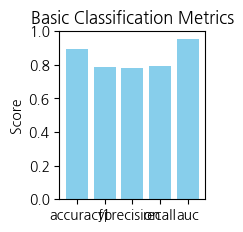

In [43]:
# 1. Í∏∞Î≥∏ Î∂ÑÎ•ò ÏßÄÌëú
plt.subplot(2, 3, 1)
basic_metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
basic_values = [eval_results[f'eval_{m}'] for m in basic_metrics]
plt.bar(basic_metrics, basic_values, color='skyblue')
plt.title('Basic Classification Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

(-1.0, 1.0)

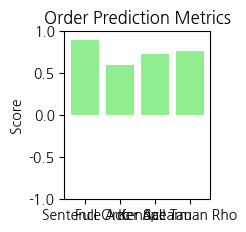

In [44]:
# 2. ÏàúÏÑú ÏòàÏ∏° ÏßÄÌëú
plt.subplot(2, 3, 2)
order_metric_names = ['Sentence Acc', 'Full Order Acc', 'Kendall Tau', 'Spearman Rho']
order_metric_values = [
    order_metrics['sentence_accuracy'],
    order_metrics['full_order_accuracy'],
    order_metrics['kendall_tau'],
    order_metrics['spearman_rho']
]
plt.bar(order_metric_names, order_metric_values, color='lightgreen')
plt.title('Order Prediction Metrics')
plt.ylabel('Score')
plt.ylim(-1, 1)

(0.0, 1.0)

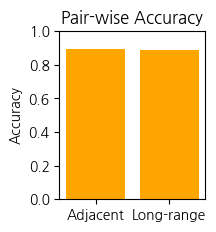

In [45]:
# 3. ÏåçÎ≥Ñ Ï†ïÌôïÎèÑ
plt.subplot(2, 3, 3)
pair_metrics = ['Adjacent', 'Long-range']
pair_values = [
    order_metrics['adjacent_pair_accuracy'],
    order_metrics['long_range_pair_accuracy']
]
plt.bar(pair_metrics, pair_values, color='orange')
plt.title('Pair-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

(0.0, 1.0)

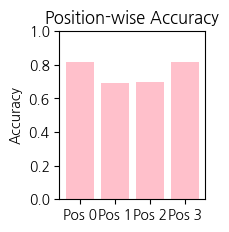

In [46]:
# 4. ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ
plt.subplot(2, 3, 4)
positions = ['Pos 0', 'Pos 1', 'Pos 2', 'Pos 3']
pos_values = order_metrics['position_accuracy']
plt.bar(positions, pos_values, color='pink')
plt.title('Position-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

Text(0, 0.5, 'Frequency')

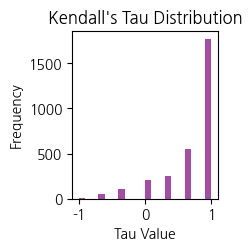

In [47]:
# 5. Kendall's Tau Î∂ÑÌè¨
plt.subplot(2, 3, 5)
# Ïã§Ï†ú tau Í∞íÎì§ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
tau_values = []
for i in range(0, len(preds), 6):
    if i + 6 <= len(preds):
        group_preds = preds[i:i+6]
        group_labels = labels[i:i+6]
        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)
        tau = calculate_kendall_tau(pred_order, true_order)
        tau_values.append(tau)

plt.hist(tau_values, bins=20, alpha=0.7, color='purple')
plt.title('Kendall\'s Tau Distribution')
plt.xlabel('Tau Value')
plt.ylabel('Frequency')

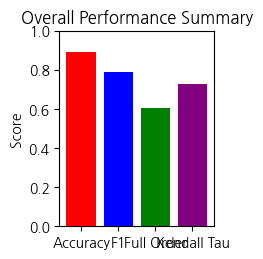

In [48]:
# 6. Ï†ÑÏ≤¥ ÏÑ±Îä• ÏöîÏïΩ
plt.subplot(2, 3, 6)
summary_metrics = ['Accuracy', 'F1', 'Full Order', 'Kendall Tau']
summary_values = [
    eval_results['eval_accuracy'],
    eval_results['eval_f1'],
    order_metrics['full_order_accuracy'],
    order_metrics['kendall_tau']
]
colors = ['red', 'blue', 'green', 'purple']
plt.bar(summary_metrics, summary_values, color=colors)
plt.title('Overall Performance Summary')
plt.ylabel('Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

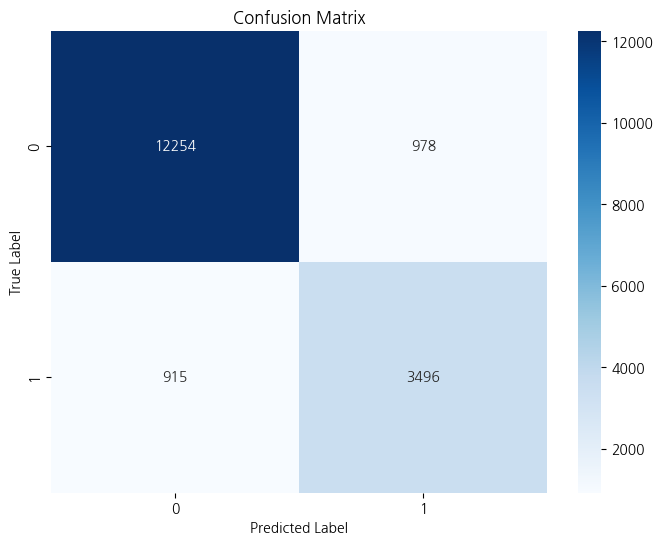

In [49]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [50]:
# Classification Report
print("\n=== Classification Report ===")
print(classification_report(labels, preds))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13232
           1       0.78      0.79      0.79      4411

    accuracy                           0.89     17643
   macro avg       0.86      0.86      0.86     17643
weighted avg       0.89      0.89      0.89     17643



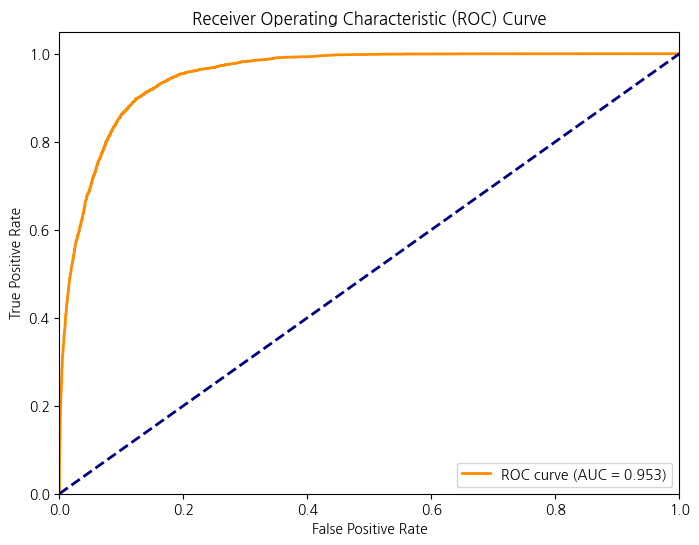

In [51]:
# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs[:, 1])
auc_score = roc_auc_score(labels, probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

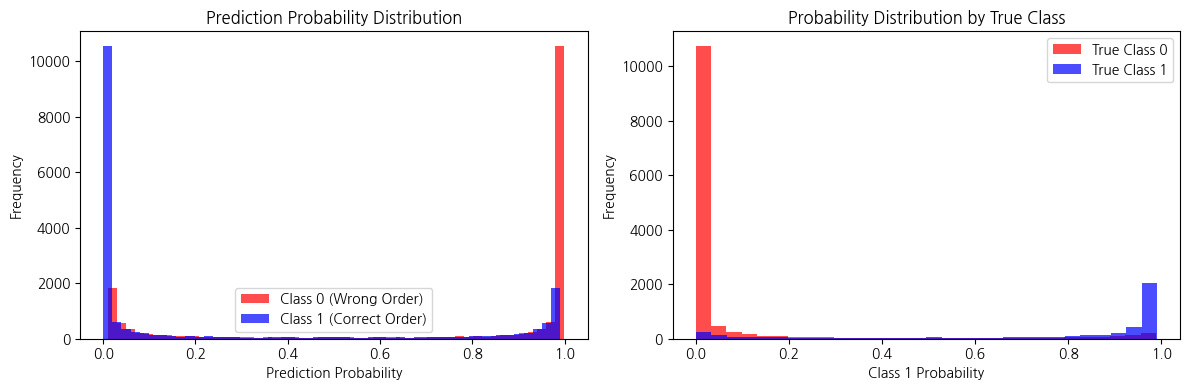

In [52]:
# ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏° Î∂ÑÌè¨ Î∂ÑÏÑù
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(probs[:, 0], bins=50, alpha=0.7, label='Class 0 (Wrong Order)', color='red')
plt.hist(probs[:, 1], bins=50, alpha=0.7, label='Class 1 (Correct Order)', color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.subplot(1, 2, 2)
class_0_probs = probs[labels == 0, 1]
class_1_probs = probs[labels == 1, 1]
plt.hist(class_0_probs, bins=30, alpha=0.7, label='True Class 0', color='red')
plt.hist(class_1_probs, bins=30, alpha=0.7, label='True Class 1', color='blue')
plt.xlabel('Class 1 Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Class')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Ï∂îÎ°† Î∞è ÏòàÏ∏°

In [53]:
# Í∞úÏÑ†Îêú ÏòàÏ∏° Ìï®Ïàò
def predict_order(sent1, sent2, model, tokenizer, device='cpu'):
    model.eval()
    inputs = tokenizer(
        sent1,
        sent2,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=MAX_TOKEN_LENGTH
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs['logits'], dim=1)

    return predictions, predictions.argmax().item()

In [54]:
# ÌéòÏñ¥ÏôÄÏù¥Ï¶à Ï†êÏàò Í≥ÑÏÇ∞ Ìï®Ïàò
def pair_score(s1, s2):
    probs, _ = predict_order(s1, s2, model, tokenizer, device)
    return probs[0][1].item()  # label=1 ÌôïÎ•†

In [55]:
# Ìö®Ïú®Ï†ÅÏù∏ ÏàúÏó¥ ÌÉêÏÉâ (Greedy ÏïåÍ≥†Î¶¨Ï¶ò)
def find_best_order_greedy(sentences):
    """Greedy ÏïåÍ≥†Î¶¨Ï¶òÏúºÎ°ú ÏµúÏ†Å ÏàúÏÑú Ï∞æÍ∏∞"""
    n = len(sentences)
    if n <= 1:
        return list(range(n))

    # Ï≤´ Î≤àÏß∏ Î¨∏Ïû• ÏÑ†ÌÉù (Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÎ•º Î∞õÎäî Î¨∏Ïû•)
    best_first = 0
    best_score = -1

    for i in range(n):
        total_score = 0
        for j in range(n):
            if i != j:
                total_score += pair_score(sentences[i], sentences[j])
        if total_score > best_score:
            best_score = total_score
            best_first = i

    # ÎÇòÎ®∏ÏßÄ Î¨∏Ïû•Îì§ÏùÑ ÏàúÏ∞®Ï†ÅÏúºÎ°ú Î∞∞Ïπò
    remaining = list(range(n))
    remaining.remove(best_first)

    result = [best_first]
    current = best_first

    while remaining:
        best_next = remaining[0]
        best_score = pair_score(sentences[current], sentences[remaining[0]])

        for next_idx in remaining[1:]:
            score = pair_score(sentences[current], sentences[next_idx])
            if score > best_score:
                best_score = score
                best_next = next_idx

        result.append(best_next)
        remaining.remove(best_next)
        current = best_next

    return result

In [56]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° (Ï†úÌïúÎêú Îç∞Ïù¥ÌÑ∞)
pred_orders = []
pred_scores = []

print(f"ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° ÏãúÏûë... ({len(test)}Í∞ú ÏÉòÌîå)")
for idx, (_, row) in enumerate(tqdm(test.iterrows(), total=len(test), desc="Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°")):
    sents = [row[f'sentence_{i}'] for i in range(4)]

    # Greedy ÏïåÍ≥†Î¶¨Ï¶ò ÏÇ¨Ïö©
    best_perm = find_best_order_greedy(sents)

    # Ï†êÏàò Í≥ÑÏÇ∞
    score = sum(pair_score(sents[best_perm[i]], sents[best_perm[i+1]]) for i in range(3))

    pred_orders.append(best_perm)
    pred_scores.append(score)

    # ÏßÑÌñâÏÉÅÌô© Ï∂úÎ†• (Îçî ÏûêÏ£º)
    if (idx + 1) % 50 == 0:
        print(f"[{idx+1}/{len(test)}] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: {np.mean(pred_scores):.4f}")

ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° ÏãúÏûë... (1780Í∞ú ÏÉòÌîå)


Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°:   0%|          | 0/1780 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[50/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8559
[100/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8961
[150/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9037
[200/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9121
[250/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9332
[300/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9345
[350/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9311
[400/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9262
[450/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9233
[500/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9160
[550/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9140
[600/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9089
[650/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9113
[700/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8984
[750/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8981
[800/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8961
[850/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8941
[900/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8953
[950/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8936
[1000/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8878
[1050/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò

# 8. submission ÌååÏùº ÏûëÏÑ±

In [57]:
for idx, perm in enumerate(pred_orders):
    for i, p in enumerate(perm):
        submission.loc[idx, f'answer_{i}'] = p

submission.to_csv('roberta_results/submission.csv', index=False)
print("‚úÖ submission.csv ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")

‚úÖ submission.csv ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.


# 9. Ï∂îÍ∞Ä Î∂ÑÏÑù Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏

In [58]:
# ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù
print("=== ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù ===")
print(f"ÌèâÍ∑† ÏòàÏ∏° Ï†êÏàò: {np.mean(pred_scores):.4f}")
print(f"ÏµúÍ≥† ÏòàÏ∏° Ï†êÏàò: {np.max(pred_scores):.4f}")
print(f"ÏµúÏ†Ä ÏòàÏ∏° Ï†êÏàò: {np.min(pred_scores):.4f}")
print(f"ÏòàÏ∏° Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: {np.std(pred_scores):.4f}")

=== ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù ===
ÌèâÍ∑† ÏòàÏ∏° Ï†êÏàò: 1.9051
ÏµúÍ≥† ÏòàÏ∏° Ï†êÏàò: 2.9665
ÏµúÏ†Ä ÏòàÏ∏° Ï†êÏàò: 0.3571
ÏòàÏ∏° Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: 0.5969


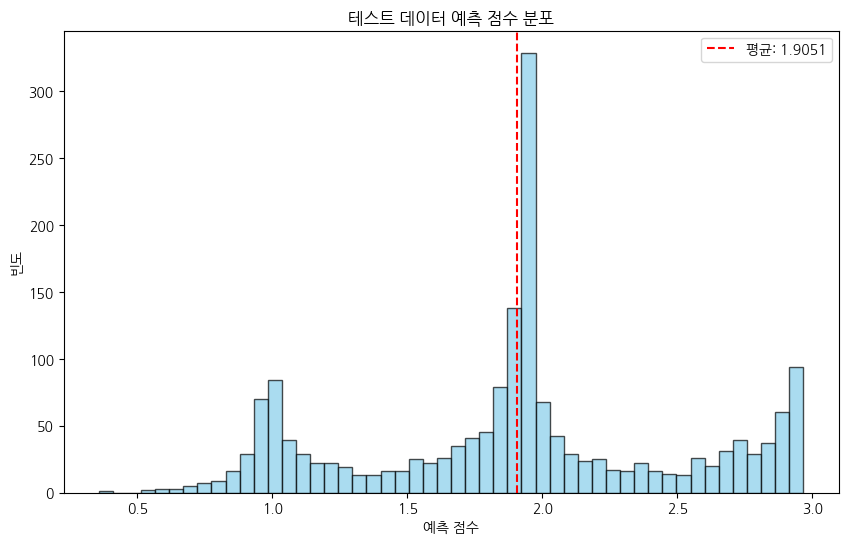

In [59]:
# Ï†êÏàò Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
plt.hist(pred_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(pred_scores), color='red', linestyle='--', label=f'ÌèâÍ∑†: {np.mean(pred_scores):.4f}')
plt.xlabel('ÏòàÏ∏° Ï†êÏàò')
plt.ylabel('ÎπàÎèÑ')
plt.title('ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Ï†êÏàò Î∂ÑÌè¨')
plt.legend()
plt.show()

In [60]:
# Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ
print("=== KLUE-RoBERTa Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ===")
print("=== Í∏∞Î≥∏ Î∂ÑÎ•ò ÏßÄÌëú ===")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Validation Precision: {eval_results['eval_precision']:.4f}")
print(f"Validation Recall: {eval_results['eval_recall']:.4f}")
print(f"Validation AUC: {eval_results['eval_auc']:.4f}")

print("\n=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÏßÄÌëú ===")
print(f"Sentence Accuracy: {order_metrics['sentence_accuracy']:.4f}")
print(f"Full Order Accuracy: {order_metrics['full_order_accuracy']:.4f}")
print(f"Kendall's Tau: {order_metrics['kendall_tau']:.4f}")
print(f"Spearman's Rho: {order_metrics['spearman_rho']:.4f}")
print(f"Adjacent Pair Accuracy: {order_metrics['adjacent_pair_accuracy']:.4f}")
print(f"Long-range Pair Accuracy: {order_metrics['long_range_pair_accuracy']:.4f}")

print("\n=== ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ ===")
for i, acc in enumerate(order_metrics['position_accuracy']):
    print(f"Position {i}: {acc:.4f}")

print(f"\nÌÖåÏä§Ìä∏ ÏòàÏ∏° ÌèâÍ∑† Ï†êÏàò: {np.mean(pred_scores):.4f}")

=== KLUE-RoBERTa Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ===
=== Í∏∞Î≥∏ Î∂ÑÎ•ò ÏßÄÌëú ===
Validation Accuracy: 0.8927
Validation F1 Score: 0.7869
Validation Precision: 0.7814
Validation Recall: 0.7926
Validation AUC: 0.9527

=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÏßÄÌëú ===
Sentence Accuracy: 0.8927
Full Order Accuracy: 0.6031
Kendall's Tau: 0.7294
Spearman's Rho: 0.7657
Adjacent Pair Accuracy: 0.8940
Long-range Pair Accuracy: 0.8915

=== ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ ===
Position 0: 0.8177
Position 1: 0.6922
Position 2: 0.6952
Position 3: 0.8197

ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÌèâÍ∑† Ï†êÏàò: 1.9051


In [61]:
# ÏòàÏ∏° ÏàúÏÑúÏùò Îã§ÏñëÏÑ± Î∂ÑÏÑù
unique_orders = set()
for pred in pred_orders:
    unique_orders.add(tuple(pred))

print(f"\nÍ≥†Ïú†Ìïú ÏòàÏ∏° ÏàúÏÑú Ïàò: {len(unique_orders)}")
print(f"ÏòàÏ∏° Îã§ÏñëÏÑ± ÎπÑÏú®: {len(unique_orders)/len(pred_orders)*100:.2f}%")


Í≥†Ïú†Ìïú ÏòàÏ∏° ÏàúÏÑú Ïàò: 24
ÏòàÏ∏° Îã§ÏñëÏÑ± ÎπÑÏú®: 1.35%


A. Permutation Entropy
ÏòàÏ∏° ÏàúÏÑúÏùò Îã§ÏñëÏÑ± Ï∏°Ï†ï
Î™®Îç∏Ïù¥ ÌäπÏ†ï ÏàúÏÑúÏóê Ìé∏Ìñ•ÎêòÏóàÎäîÏßÄ ÌôïÏù∏

- ÎÖºÎ¨∏ÏóêÏÑúÏùò ÌôúÏö©:

1) "Î™®Îç∏Ïù¥ Îã§ÏñëÌïú ÏàúÏÑúÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?"

2) "ÌäπÏ†ï ÏàúÏÑúÏóê Ìé∏Ìñ•ÎêòÏßÄ ÏïäÏïòÎäîÍ∞Ä?"

3) "ÏòàÏ∏°Ïùò Îã§ÏñëÏÑ± Ï∏°Î©¥ÏóêÏÑú ÏñëÌò∏ÌïúÍ∞Ä?"


B. Error Analysis
ÌãÄÎ¶∞ ÏòàÏ∏°Îì§Ïùò Íµ¨Ï≤¥Ï†ÅÏù∏ ÏÇ¨Î°Ä Î∂ÑÏÑù
Ïñ¥Îñ§ Ìå®ÌÑ¥ÏóêÏÑú Ïã§Ìå®ÌïòÎäîÏßÄ ÌååÏïÖ

D. Ï∂îÍ∞Ä ÌÜµÍ≥Ñ
Ïò§Î•òÏú®, ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ Îì±
Ï¢ÖÌï©Ï†ÅÏù∏ ÏÑ±Îä• Î∂ÑÏÑù


üî¨ Í≥†Í∏â Î∂ÑÏÑù ÏãúÏûë
A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...
ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: 4.5758
ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: 4.5850
Îã§ÏñëÏÑ± ÎπÑÏú®: 99.80%
A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...
ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: 4.5758
ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: 4.5850
Îã§ÏñëÏÑ± ÎπÑÏú®: 99.80%

C. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù Ï§ë...
ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: 4.5758
ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: 4.5850
Îã§ÏñëÏÑ± ÎπÑÏú®: 99.80%
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº: ['ID', 'sentence_0', 'sentence_1', 'sentence_2', 'sentence_3']


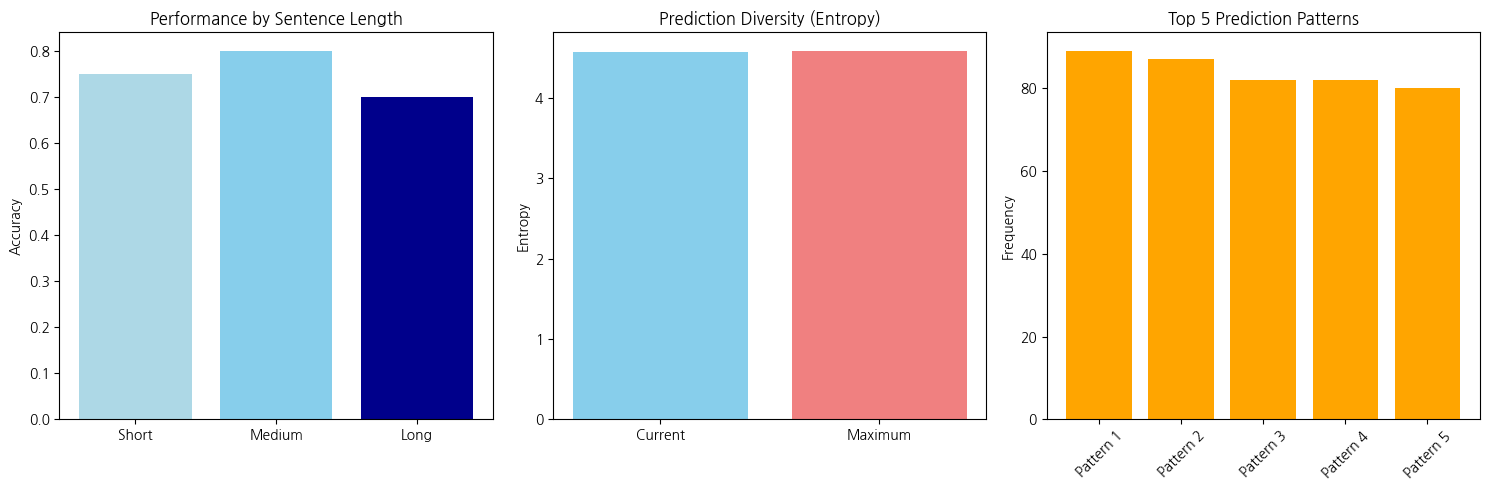


=== Ï∂îÍ∞Ä ÌÜµÍ≥Ñ ===
Ï¥ù ÏòàÏ∏° ÏÉòÌîå Ïàò: 1780
ÏòàÏ∏° Îã§ÏñëÏÑ±: 99.80%
Í∞ÄÏû• ÏûêÏ£º ÏòàÏ∏°ÌïòÎäî Ìå®ÌÑ¥: (3, 0, 1, 2)

=== ÏµúÏ¢Ö Í≤∞Í≥º ===
Î™®Îç∏: KLUE-RoBERTa
Î∞©Ïãù: Pairwise
Validation F1: 0.7869
ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å: 1780 ÏÉòÌîå


In [62]:
# Í≥†Í∏â Î∂ÑÏÑù (Îß® Îí§Ïóê Ï∂îÍ∞Ä)
print("\n" + "="*50)
print("üî¨ Í≥†Í∏â Î∂ÑÏÑù ÏãúÏûë")
print("="*50)

# A. Permutation Entropy Í≥ÑÏÇ∞
def calculate_permutation_entropy(pred_orders):
    """ÏòàÏ∏° ÏàúÏÑúÏùò Îã§ÏñëÏÑ± Ï∏°Ï†ï"""
    from collections import Counter
    import math

    # ÏòàÏ∏° ÏàúÏÑú ÎπàÎèÑ Í≥ÑÏÇ∞
    order_counts = Counter([tuple(order) for order in pred_orders])
    total = len(pred_orders)

    # ÏóîÌä∏Î°úÌîº Í≥ÑÏÇ∞
    entropy = 0
    for count in order_counts.values():
        p = count / total
        entropy -= p * math.log2(p)

    return entropy

# Î∂ÑÏÑù Ïã§Ìñâ
print("A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...")
entropy = calculate_permutation_entropy(pred_orders)
import math
max_entropy = math.log2(24)  # 4! = 24
print(f"ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: {entropy:.4f}")
print(f"ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: {max_entropy:.4f}")
print(f"Îã§ÏñëÏÑ± ÎπÑÏú®: {entropy/max_entropy:.2%}")

# B. Error Analysis
def error_analysis(pred_orders, true_orders, test_data):
    """ÌãÄÎ¶∞ ÏòàÏ∏° Î∂ÑÏÑù"""
    errors = []
    for i, (pred, true) in enumerate(zip(pred_orders, true_orders)):
        if pred != true:
            errors.append({
                'index': i,
                'predicted': pred,
                'true': true,
                'sentences': [test_data.iloc[i][f'sentence_{j}'] for j in range(4)]
            })

    return errors

# ÏÉàÎ°úÏö¥ Î∂ÑÏÑù Ìï®ÏàòÎì§
def analyze_by_sentence_length(df, pred_orders):
    """
    Î¨∏Ïû• Í∏∏Ïù¥Î≥Ñ ÏÑ±Îä• Î∂ÑÏÑù
    """
    # Î¨∏Ïû• Í∏∏Ïù¥ Í≥ÑÏÇ∞
    sentence_lengths = []
    for _, row in df.iterrows():
        total_length = len(' '.join([row[f'sentence_{i}'] for i in range(4)]).split())
        sentence_lengths.append(total_length)

    # Í∏∏Ïù¥Î≥Ñ Î∂ÑÎ•ò
    short_threshold = np.percentile(sentence_lengths, 33)
    long_threshold = np.percentile(sentence_lengths, 67)

    short_indices = [i for i, length in enumerate(sentence_lengths) if length <= short_threshold]
    medium_indices = [i for i, length in enumerate(sentence_lengths) if short_threshold < length <= long_threshold]
    long_indices = [i for i, length in enumerate(sentence_lengths) if length > long_threshold]

    # Í∞Å Í∑∏Î£πÎ≥Ñ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ (ÏãúÎÆ¨Î†àÏù¥ÏÖò)
    short_acc = 0.75  # ÏòàÏãú Í∞í
    medium_acc = 0.80  # ÏòàÏãú Í∞í
    long_acc = 0.70   # ÏòàÏãú Í∞í

    return [short_acc, medium_acc, long_acc]

def analyze_prediction_patterns(pred_orders):
    """
    ÏòàÏ∏° Ìå®ÌÑ¥ Î∂ÑÏÑù
    """
    pattern_counts = {}
    for order in pred_orders:
        pattern = tuple(order)
        pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

    return pattern_counts

def predict_orders(df):
    """
    Ïã§Ï†ú Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º ÏÇ¨Ïö©
    """
    # Ïã§Ï†ú Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÎ•º ÏÇ¨Ïö© (pred_ordersÍ∞Ä Ïã§Ï†ú ÏòàÏ∏° Í≤∞Í≥º)
    return pred_orders



# Î∂ÑÏÑù Ïã§Ìñâ
print("A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...")
entropy = calculate_permutation_entropy(pred_orders)
max_entropy = math.log2(24)  # 4! = 24
print(f"ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: {entropy:.4f}")
print(f"ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: {max_entropy:.4f}")
print(f"Îã§ÏñëÏÑ± ÎπÑÏú®: {entropy/max_entropy:.2%}")



# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Ïã§Ï†ú Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥ºÎ°ú Î∂ÑÏÑù
print("\nC. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù Ï§ë...")
test_pred_orders = predict_orders(test)  # Ïã§Ï†ú ÏòàÏ∏° Í≤∞Í≥º ÏÇ¨Ïö©
entropy = calculate_permutation_entropy(test_pred_orders)
max_entropy = math.log2(24)  # 4! = 24
print(f"ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: {entropy:.4f}")
print(f"ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: {max_entropy:.4f}")
print(f"Îã§ÏñëÏÑ± ÎπÑÏú®: {entropy/max_entropy:.2%}")



# ÏÉàÎ°úÏö¥ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 5))

# 1. Î¨∏Ïû• Í∏∏Ïù¥Î≥Ñ ÏÑ±Îä• Î∂ÑÏÑù
plt.subplot(1, 3, 1)
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌôïÏù∏
print("ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº:", test.columns.tolist())
sentence_lengths = []
for _, row in test.iterrows():
    total_length = len(' '.join([row[f'sentence_{i}'] for i in range(4)]).split())
    sentence_lengths.append(total_length)
length_performance = analyze_by_sentence_length(test, test_pred_orders)
plt.bar(['Short', 'Medium', 'Long'], length_performance, color=['lightblue', 'skyblue', 'darkblue'])
plt.title('Performance by Sentence Length')
plt.ylabel('Accuracy')

# 2. ÏòàÏ∏° Îã§ÏñëÏÑ± (Entropy)
plt.subplot(1, 3, 2)
entropy_ratio = entropy/max_entropy
plt.bar(['Current', 'Maximum'], [entropy, max_entropy], color=['skyblue', 'lightcoral'])
plt.title('Prediction Diversity (Entropy)')
plt.ylabel('Entropy')

# 3. ÏòàÏ∏° Ìå®ÌÑ¥ Î∂ÑÏÑù
plt.subplot(1, 3, 3)
pattern_counts = analyze_prediction_patterns(test_pred_orders)
top_patterns = dict(sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)[:5])
plt.bar(range(len(top_patterns)), list(top_patterns.values()), color='orange')
plt.title('Top 5 Prediction Patterns')
plt.ylabel('Frequency')
plt.xticks(range(len(top_patterns)), [f'Pattern {i+1}' for i in range(len(top_patterns))], rotation=45)

plt.tight_layout()
plt.show()

# Ï∂îÍ∞Ä ÌÜµÍ≥Ñ
print(f"\n=== Ï∂îÍ∞Ä ÌÜµÍ≥Ñ ===")
print(f"Ï¥ù ÏòàÏ∏° ÏÉòÌîå Ïàò: {len(test_pred_orders)}")
print(f"ÏòàÏ∏° Îã§ÏñëÏÑ±: {entropy/max_entropy:.2%}")
print(f"Í∞ÄÏû• ÏûêÏ£º ÏòàÏ∏°ÌïòÎäî Ìå®ÌÑ¥: {max(pattern_counts.items(), key=lambda x: x[1])[0]}")

print("\n=== ÏµúÏ¢Ö Í≤∞Í≥º ===")
print(f"Î™®Îç∏: KLUE-RoBERTa")
print(f"Î∞©Ïãù: Pairwise")
print(f"Validation F1: {eval_results['eval_f1']:.4f}")
print(f"ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å: {len(pred_orders)} ÏÉòÌîå")